In [1]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import torch
import triton
import triton.language as tl
from fasta import *

In [2]:
def test_fasta_attention_benchmark(N, D, block_size, num_iterations):
    """
    Benchmark function for optimized FASTA attention implementation
    and standard self-attention. Includes batching for efficiency.
    """

    device = 'cuda'

    assert torch.cuda.is_available(), "CUDA is not available. Please run on a CUDA-enabled device."

    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)

    Q_fasta = Q.unsqueeze(0).unsqueeze(0)
    K_fasta = K.unsqueeze(0).unsqueeze(0)

    print("Computing standard self-attention for all iterations...")
    standard_times = []
    standard_outputs = []

    for idx in tqdm(range(num_iterations), desc="Standard Self-Attention"):
        start_std = torch.cuda.Event(enable_timing=True)
        end_std = torch.cuda.Event(enable_timing=True)

        start_std.record()
        attn_ref = Q @ K.T
        end_std.record()

        torch.cuda.synchronize()
        elapsed_std = start_std.elapsed_time(end_std)
        standard_times.append(elapsed_std)
        if idx % 1000 == 0:
            standard_outputs.append(attn_ref.detach().cpu().numpy())

    print("Computing optimized FASTA attention for all iterations...")
    fasta_times = []
    fasta_outputs = []

    for idx in tqdm(range(num_iterations), desc="FASTA Attention"):
        start_fasta = torch.cuda.Event(enable_timing=True)
        end_fasta = torch.cuda.Event(enable_timing=True)

        start_fasta.record()
        attn_fasta = fasta_minhash_tiled(Q_fasta, K_fasta).squeeze(0).squeeze(0)
        end_fasta.record()

        torch.cuda.synchronize()
        elapsed_fasta = start_fasta.elapsed_time(end_fasta)
        fasta_times.append(elapsed_fasta)
        if idx % 1000 == 0:
            fasta_outputs.append(attn_fasta.detach().cpu().numpy())

    standard_times = np.array(standard_times)
    fasta_times = np.array(fasta_times)

    print("Computing error metrics...")
    mae_list = []
    max_error_list = []
    relative_error_list = []

    for ref, fasta in zip(standard_outputs, fasta_outputs):
        abs_diff = np.abs(ref - fasta)
        mae_list.append(abs_diff.mean().item())
        max_error_list.append(abs_diff.max().item())
        relative_error_list.append((abs_diff / np.abs(ref + 1e-6)).mean().item())

    print("Benchmarking completed!")
    print("\nTiming Statistics:")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    print(f"FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Percentage Improvement: {100 * (1 - fasta_times.mean() / standard_times.mean()):.2f}%")

    print("\nError Metrics (Average over all iterations):")
    print(f"Mean Absolute Error (MAE): {np.mean(mae_list):.6f}")
    print(f"Maximum Absolute Error: {np.mean(max_error_list):.6f}")
    print(f"Relative Error: {np.mean(relative_error_list):.6f}")

    plt.figure(figsize=(12, 6))
    sns.histplot(fasta_times, color='blue', label='FASTA Attention', kde=True, stat="density", bins=50, alpha=0.6)
    sns.histplot(standard_times, color='orange', label='Standard Attention', kde=True, stat="density", bins=50, alpha=0.6)
    plt.title('Timing Distributions')
    plt.xlabel('Time (ms)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    return standard_outputs, fasta_outputs


In [3]:
N = 1024
D = 512
block_size = 64
num_iter = 10000

Computing standard self-attention for all iterations...


Standard Self-Attention: 100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4907.34it/s]


Computing optimized FASTA attention for all iterations...


FASTA Attention: 100%|███████████████████████████████████████████| 10000/10000 [00:01<00:00, 6053.81it/s]


Computing error metrics...
Benchmarking completed!

Timing Statistics:
Standard Self-Attention - Mean: 0.1773 ms, Std: 0.0146 ms
FASTA Attention - Mean: 0.1421 ms, Std: 0.0375 ms
Percentage Improvement: 19.85%

Error Metrics (Average over all iterations):
Mean Absolute Error (MAE): 17.491611
Maximum Absolute Error: 118.526604
Relative Error: 2.044891


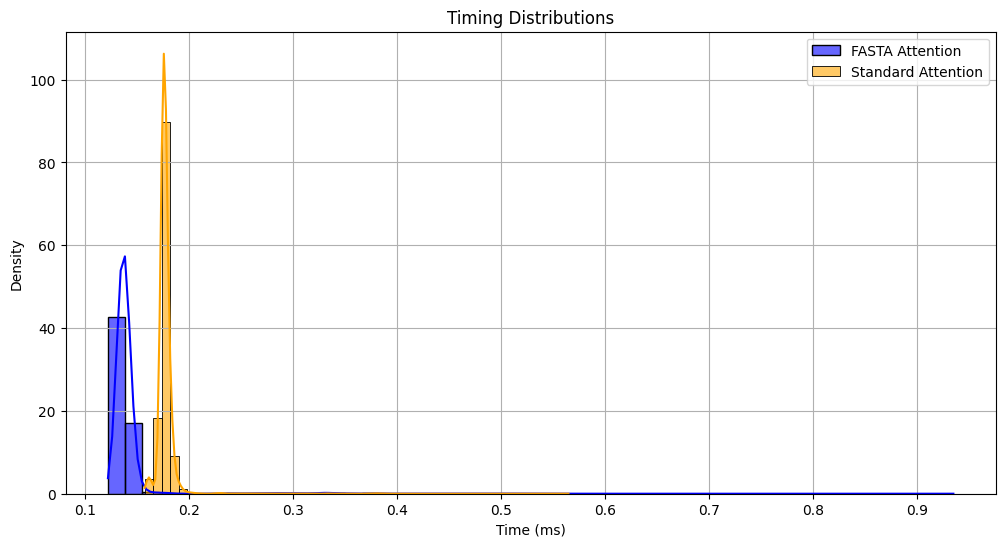

In [5]:
standard_outputs, fasta_outputs = test_fasta_attention_benchmark(N,D,block_size,num_iter)

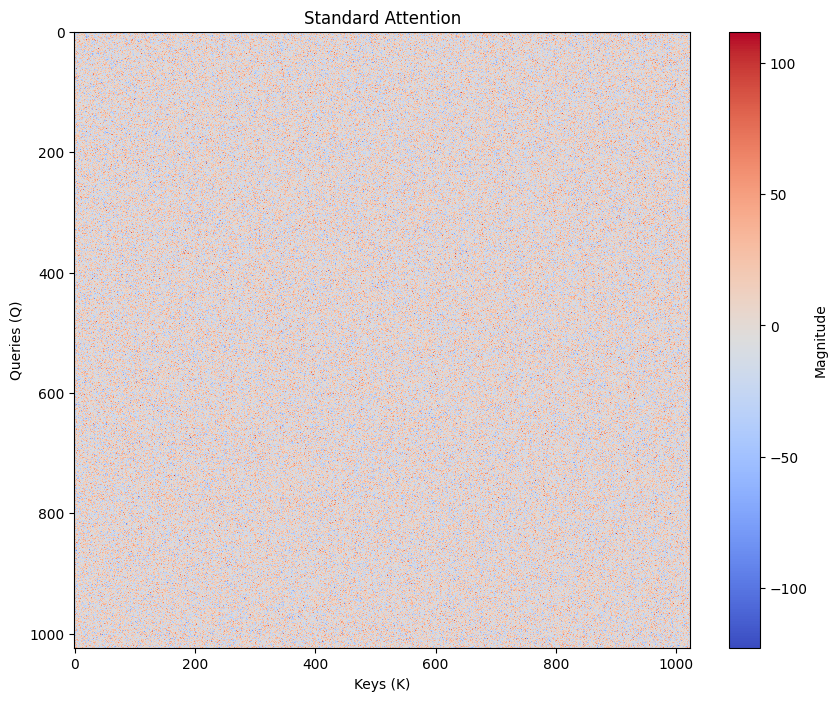

In [6]:
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(standard_outputs[0].squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Magnitude")
plt.title("Standard Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

In [7]:
standard_outputs[0][0].mean()

0.602718

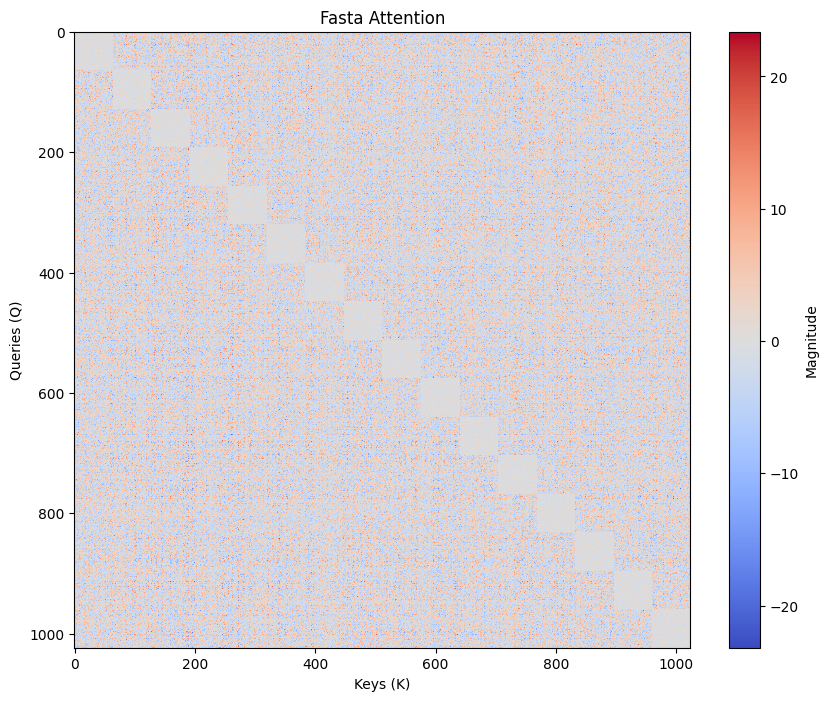

In [8]:
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(fasta_outputs[0].squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Magnitude")
plt.title("Fasta Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

In [9]:
standard_outputs[0].max(), standard_outputs[0].min(), standard_outputs[0].mean(), standard_outputs[0].std()

(112.05147, -122.93659, 0.015453894, 22.598597)

In [10]:
fasta_outputs[0].max(), fasta_outputs[0].min(), fasta_outputs[0].mean(), fasta_outputs[0].std()

(23.376776, -23.191523, 0.0015733212, 3.9868164)

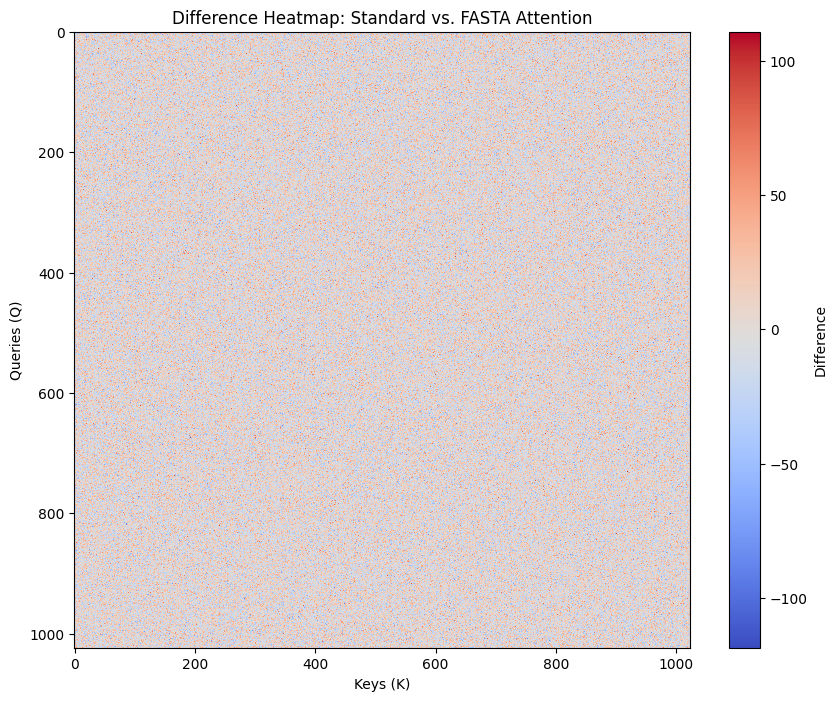

Maximum difference is: 110.7630844116211


In [15]:
difference = (standard_outputs[0] - fasta_outputs[0])
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(difference.squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Difference")
plt.title("Difference Heatmap: Standard vs. FASTA Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

print(f"Maximum difference is: {difference.max()}")

In [12]:
matrix = standard_outputs[0] / fasta_outputs[0]  # The ratio matrix

# Get the number of grids in each dimension
num_grids_x = matrix.shape[1] // block_size
num_grids_y = matrix.shape[0] // block_size

# Initialize variables to track max ratio and its grid position
max_ratio = -np.inf
max_grid = (0, 0)

# Iterate over grids
for i in range(num_grids_y):
    for j in range(num_grids_x):
        # Extract the current grid
        grid = matrix[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        
        # Compute the maximum ratio in the grid
        grid_max = np.max(grid)
        
        
        # Update max_ratio and max_grid if this grid has a higher max
        if grid_max > max_ratio:
            max_ratio = grid_max
            max_grid = (i, j)

# Output the result
print(f"Maximum ratio is {max_ratio} in grid (row, col): {max_grid}")

Maximum ratio is 694537.75 in grid (row, col): (3, 15)


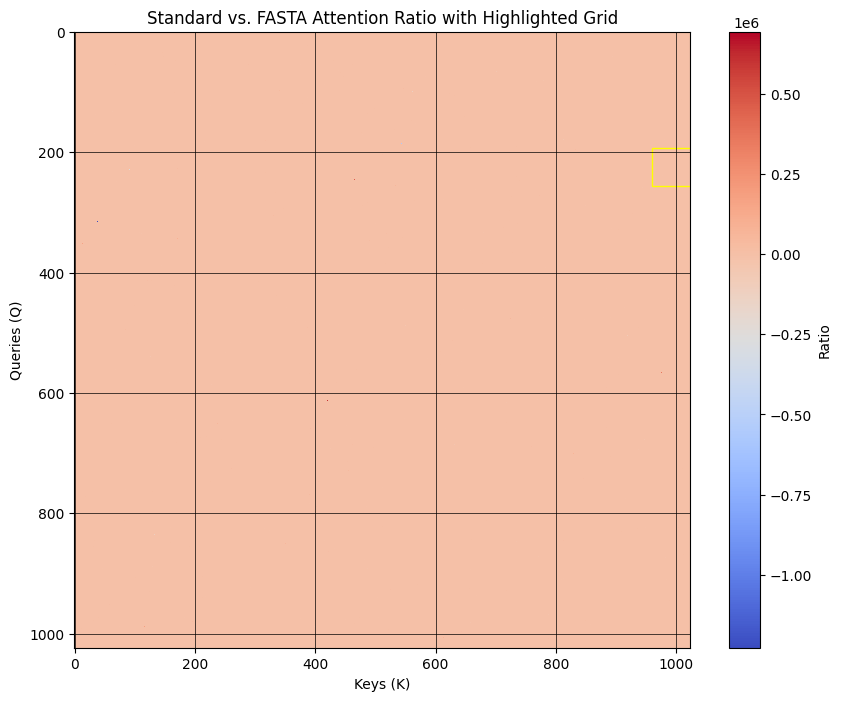

In [13]:
# Highlight the grid
plt.figure(figsize=(10, 8))
plt.imshow(standard_outputs[0] / fasta_outputs[0], cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Ratio")
plt.title("Standard vs. FASTA Attention Ratio with Highlighted Grid")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Add grid lines
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)

# Highlight the grid
rect_x = max_grid[1] * block_size
rect_y = max_grid[0] * block_size
rect = plt.Rectangle((rect_x, rect_y), block_size, block_size, edgecolor='yellow', facecolor='none', lw=1)
plt.gca().add_patch(rect)

plt.show()

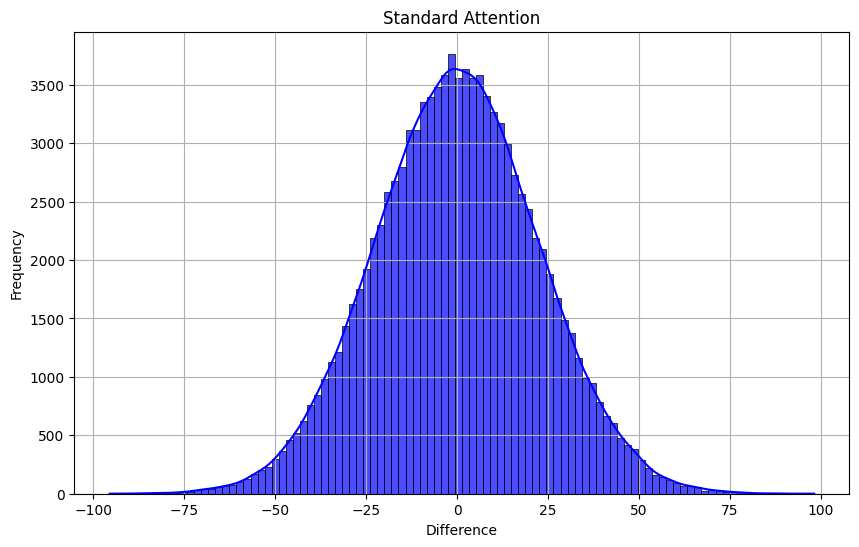

In [14]:
# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(standard_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Standard Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


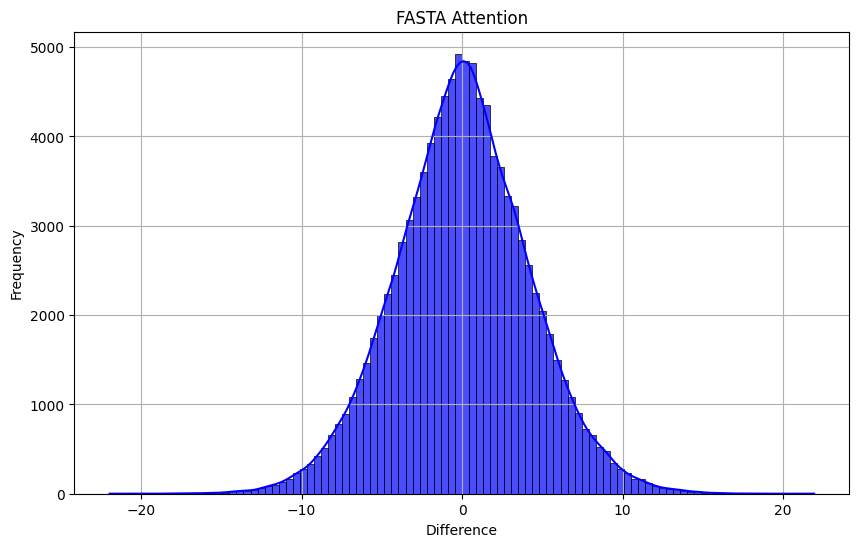

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(fasta_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

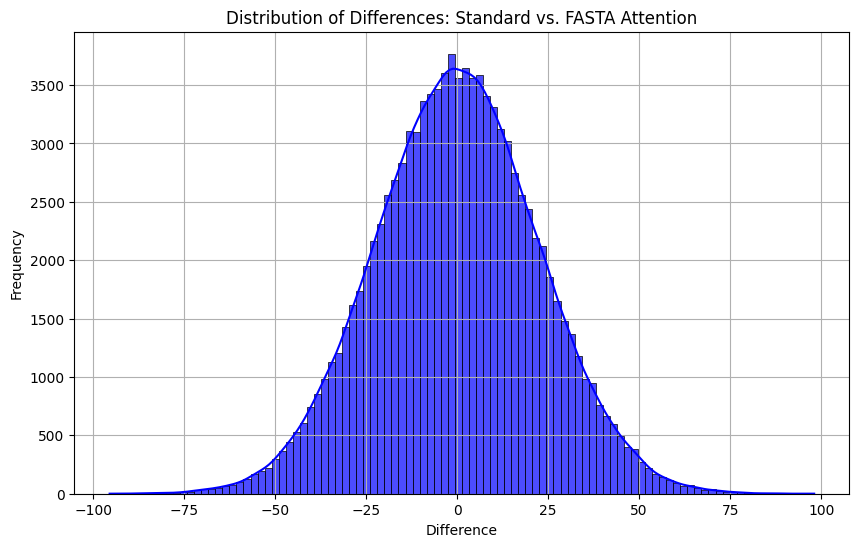

In [35]:
subsampled_difference = difference.flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Differences: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

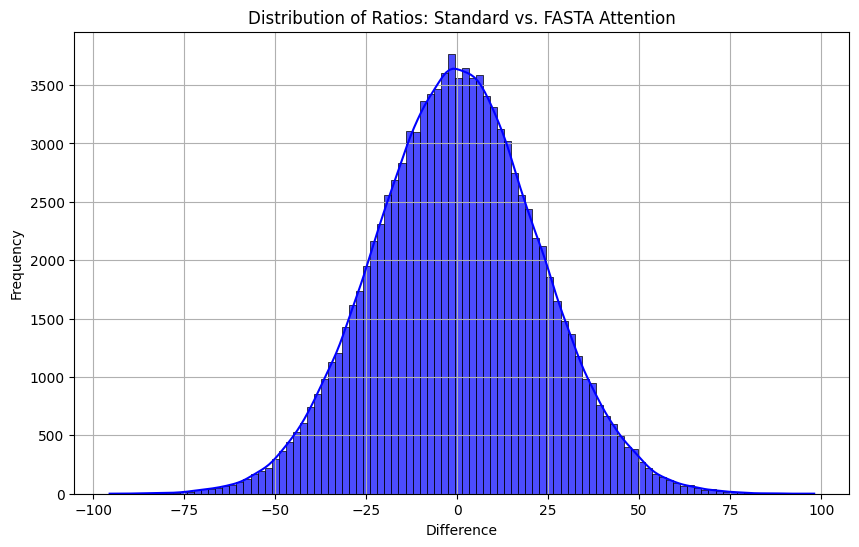

In [36]:
subsampled_ratio = (standard_outputs[0] / fasta_outputs[0]).flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Ratios: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [37]:
row_block_idx,col_block_idx = max_grid

# Compute Q indices
q_start = row_block_idx * block_size
q_end = (row_block_idx + 1) * block_size - 1

# Compute K indices
k_start = col_block_idx * block_size
k_end = (col_block_idx + 1) * block_size - 1

print(f"Q indices for block (row=6): {q_start} to {q_end}")
print(f"K indices for block (col=4): {k_start} to {k_end}")

Q indices for block (row=6): 704 to 767
K indices for block (col=4): 512 to 575


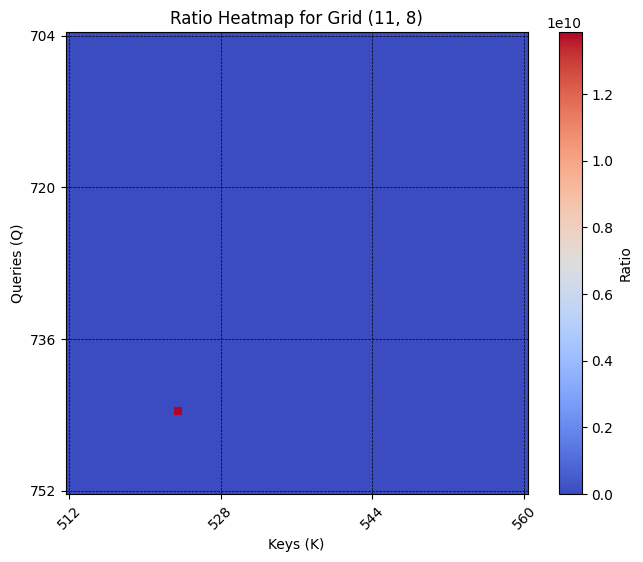

In [38]:
# Compute indices for the highlighted grid
q_start = max_grid[0] * block_size
q_end = (max_grid[0] + 1) * block_size
k_start = max_grid[1] * block_size
k_end = (max_grid[1] + 1) * block_size

# Extract the submatrix for the highlighted grid
highlighted_block = (standard_outputs[0] / fasta_outputs[0])[q_start:q_end, k_start:k_end]

# Generate x and y tick labels for indices
q_indices = np.arange(q_start, q_end, block_size // 4)  # Adjust granularity as needed
k_indices = np.arange(k_start, k_end, block_size // 4)

# Plot the heatmap for the highlighted block
plt.figure(figsize=(8, 6))
im = plt.imshow(highlighted_block, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im, label="Ratio")
plt.title(f"Ratio Heatmap for Grid ({max_grid[0]}, {max_grid[1]})")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Set custom ticks for better index clarity
plt.xticks(ticks=np.linspace(0, block_size - 1, len(k_indices)), labels=k_indices, rotation=45)
plt.yticks(ticks=np.linspace(0, block_size - 1, len(q_indices)), labels=q_indices)

# Add grid lines for each block cell
plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5)

plt.show()